[View in Colaboratory](https://colab.research.google.com/github/Oubunhaku/deeplearningclass/blob/master/%E2%80%9C(17M18765)_report2_ipynb%E2%80%9D.ipynb)

# Machine Learning: Intermediate report

+ WANG Wenbo (17M18765)

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following three (and one optional) problems, and submit the notebook (`.ipynb`) as well as its HTML conversion (`.html`). *We do not accept a report in other formats (e.g., Word, PDF)*. Write a code at the specified cell in the notebook. One can add more cells if necessary.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearningclass/blob/master/mlp_binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearningclass/blob/master/mnist.ipynb)

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the accuracy of the model on the test set. One can use the same code shown in the lecture. Write a code here and show the output.

In [0]:
! pip install torch==0.4.0
! pip install torchvision
! pip install livelossplot

In [0]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

In [0]:
# download mnist dataset into "data" automatically
data = np.load('mnist.npz')   

# make train and test set
train_set = create_dataset(data['train_x'],data['train_y'])
test_set = create_dataset(data['test_x'],data['test_y'])
train_loader = DataLoader(train_set,batch_size=256,shuffle=True)
test_set = DataLoader(test_set,batch_size=128)

In [0]:
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np

# numpy to tensor
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)


def test_model(model, loss_func, test_loader):
    model.eval()
    
    loss = 0.
    num_correct = 0.
    for batch, (b_x,b_y) in enumerate(test_loader):       
        pred_y = model(b_x)
        loss += loss_func(pred_y, b_y).item()
        _, predicted = torch.max(pred_y.data, 1)
        num_correct += (predicted == b_y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

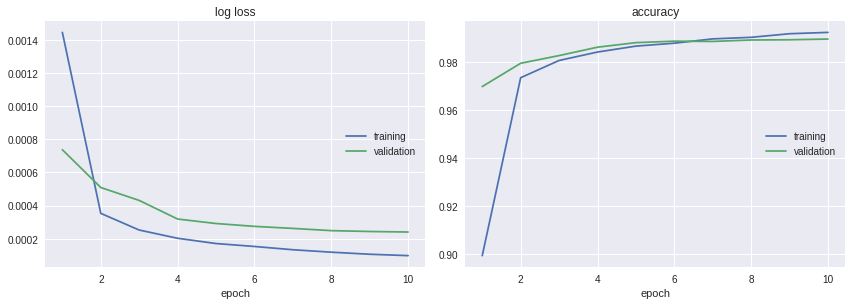

Accuracy: 0.9897 (test), 0.9925 (train)


In [54]:
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
from livelossplot import PlotLosses


# build an CNN network for mnist
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(1,16,5,1,2),
      nn.ReLU(),
      nn.MaxPool2d(2))
    self.conv2 = nn.Sequential(
      nn.Conv2d(16,32,5,1,2),
      nn.ReLU(),
      nn.MaxPool2d(2))
    self.out = nn.Linear(32*7*7,10)
    
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0),-1)
    output = self.out(x)
    return output  
cnn = CNN()

#optim and loss
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)
loss_func = nn.CrossEntropyLoss()

liveloss = PlotLosses()
# training
for t in range(10):
    train_loss = 0.
    train_correct = 0
    for step,(b_x,b_y) in enumerate(train_loader):    
        pred_y = cnn(b_x)
        loss = loss_func(pred_y, b_y)
        # Compute the correct value.
        _, predicted = torch.max(pred_y.data, 1)
        train_correct += (predicted == b_y).sum().item()
        # Compute the loss value.
        loss = loss_func(pred_y, b_y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(cnn, loss_func, test_loader)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))   


## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/Oubunhaku/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [60]:
import numpy as np
conf_matrix=np.zeros((10,10))

for batch_idx, (x, y) in enumerate(test_loader):
    pred_y = cnn(x)
    _, predicted = torch.max(pred_y.data, 1)
    for i,j in zip(predicted,y):

      conf_matrix[predicted,y]+=1
    
print(conf_matrix)

[[10000.     0.   256.   128.     0.   256.   768.     0.   384.   128.]
 [    0. 10000.   256.     0.     0.     0.   256.   256.     0.   384.]
 [    0.   256. 10000.   128.     0.     0.     0.   128.   256.     0.]
 [    0.     0.     0. 10000.     0.   512.     0.     0.   128.     0.]
 [    0.     0.   256.     0. 10000.     0.   256.     0.   128.   896.]
 [    0.     0.     0.   256.     0. 10000.   128.     0.   128.   512.]
 [    0.   128.   128.     0.     0.   128. 10000.     0.   128.   128.]
 [  256.   128.   768.   384.     0.   256.     0. 10000.   512.   640.]
 [  256.     0.   384.   128.   128.   256.     0.   128. 10000.   512.]
 [    0.     0.     0.     0.   128.   128.     0.     0.   256. 10000.]]


## 3. Top-3 confusing examples

Show the top three images where the model misrecognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n \neq \hat{y}_n$.

Please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$. This is an example of an output for an image (you need this kind of outputs for top-three images).

![example](https://github.com/Oubunhaku/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

1. The real y is 6,it's prob is 0.21% while the pred y is 0, it's prob is 0.79%


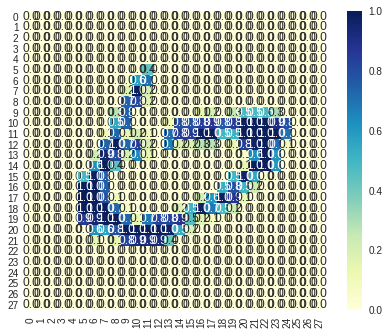

2. The real y is 6,it's prob is 0.31% while the pred y is 0, it's prob is 0.69%


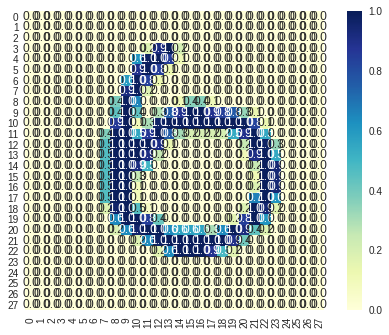

3. The real y is 5,it's prob is 0.49% while the pred y is 3, it's prob is 0.51%


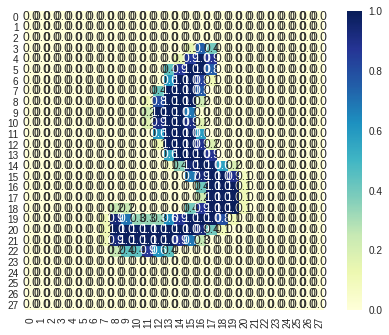

In [141]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   

save=list()#(x, real_y, prob_ry, pred_y, prob_py)
for batch, (b_x, b_y) in enumerate(test_loader):
    b_out = cnn(b_x)
    b_pred_distr = torch.nn.functional.softmax(b_out ,dim=1)
    for x,real_y,pred_distr in zip(b_x, b_y, b_pred_distr):
        prob_py, pred_y = torch.max(pred_distr, 0)    
        if (pred_y != real_y):
            if len(save) < 3:
                prob_ry = pred_distr[real_y]
                save.append([x, real_y, prob_ry, pred_y, prob_py])
            else:
                save.sort(key=lambda x: x[4],reverse=True)
                
for i in range(3):
    real_y = save[i][1]
    prob_ry = save[i][2]
    pred_y = save[i][3]
    prob_py = save[i][4]
    print('%d. The real y is %d,it\'s prob is %.2f%% while the pred y is %d, it\'s prob is %.2f%%'%(i+1,real_y, prob_ry, pred_y, prob_py))
    a=save[i][0].squeeze().tolist().copy()
    image = a
    sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
    plt.show()


## 4. Sample codes in other DL frameworks

(Advanced; optional) Implement one or more sample code(s) with a different deep learning framework (e.g., Chainer, TensorFlow, DyNet) corresponding to the slides 60-66 in binary classification. *When subitting an answer to this problem, please agree that some of the submitted codes will be distributed on the Web site to improve this lecture.*